In [101]:
!brew install libomp
!poetry add xgboost

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ad                  ggh                 libpostal-rest      sql-formatter
adapterremoval      git-mob             mac                 symfony-cli
arelo               go@1.23             md2pdf              threatcl
bacon-ls            gomi                mummer              vfkit
bagels              hcledit             nping               yamlfix
bazel@7             identme  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
import xgboost as xgb

In [2]:
data_path = '../../aws/data/feature_frame.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [49]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [50]:
#quedarnos solo con 5 ordenes de 5 o mas productos
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5 ) -> pd.DataFrame:
    """We are only interested in big enough orders that are profitable"""
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]


df_selected = (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [51]:
df_selected.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [52]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

Vamos a asegurarnos de que las ordenes no estan divididas en train y validación (la orden entera tiene que estar o en train o validación). 

Además, vamos a hacer temporal split.

In [53]:
daily_orders = df_selected.groupby('order_date').order_id.nunique()

In [54]:
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

In [55]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


In [56]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date >= train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

In [57]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date >= train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

## Baseline

Como ya hemos entrenado un modelo lineal que mejora el baseline inicial, vamos a definir el modelo lineal con 4 features como baseline 

In [58]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()
    

In [59]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

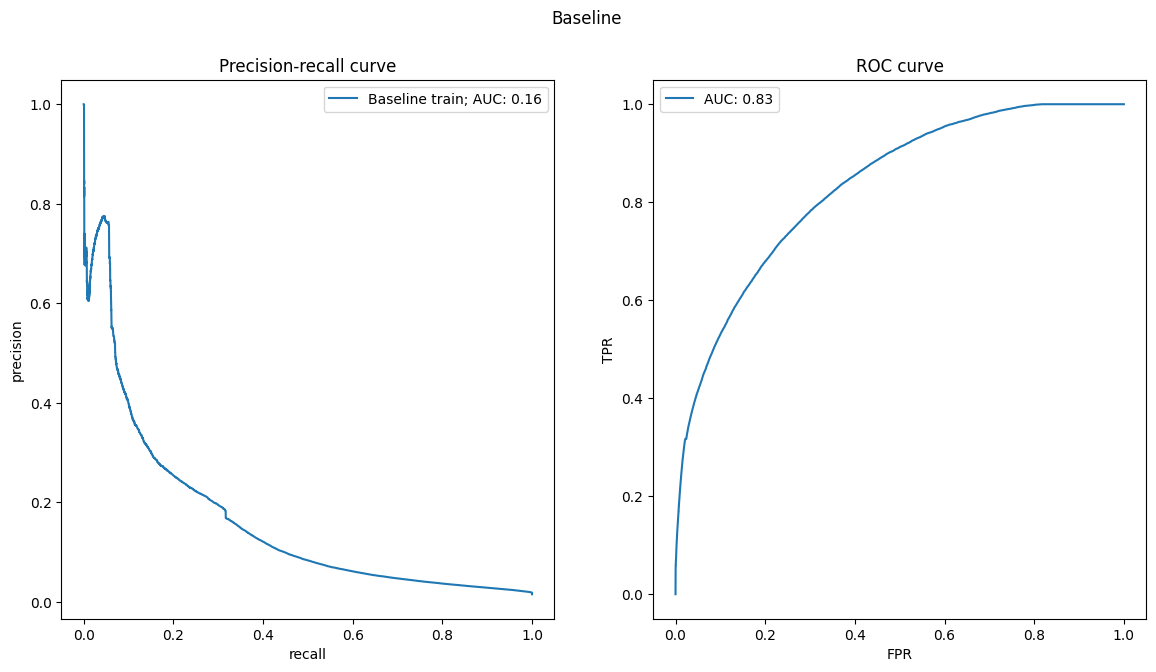

In [67]:
reduced_cols = ["ordered_before", "abandoned_before", "global_popularity"]

fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Baseline")

lr =make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6))

lr.fit(X_train[reduced_cols], y_train)
lr_train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

lr.fit(X_val[reduced_cols], y_val)
lr_val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]

plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

# Decision trees

Una vez definido el baseline, voy a empezar con decision trees con todas las features (menos categoricas).

In [61]:
train_cols = numerical_cols + binary_cols

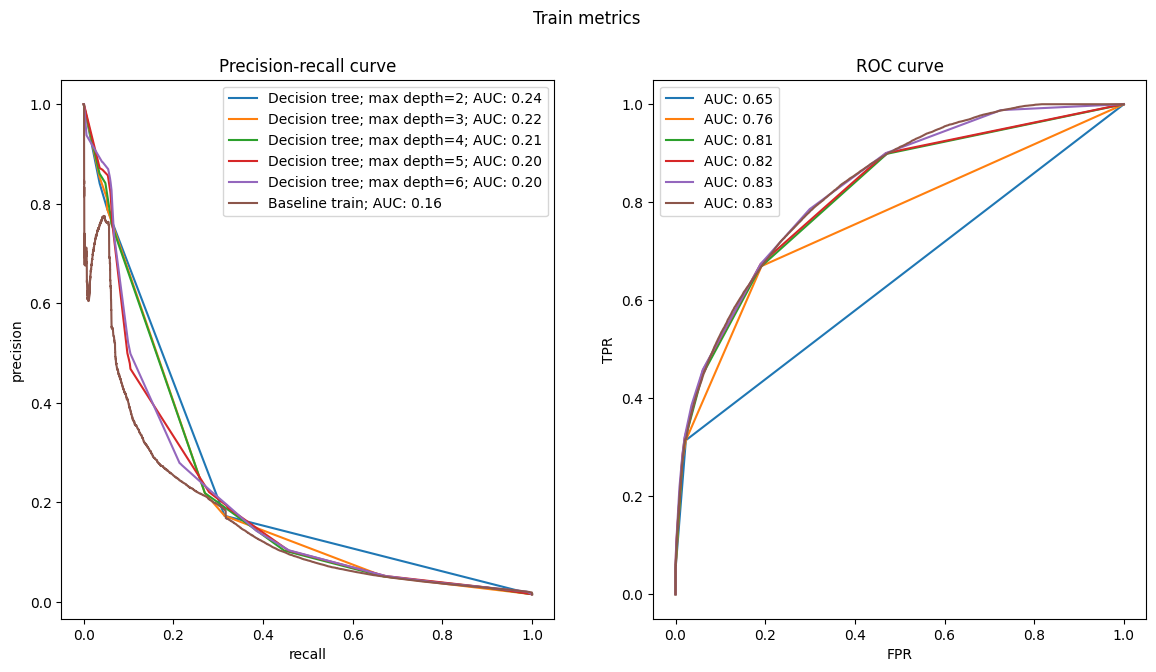

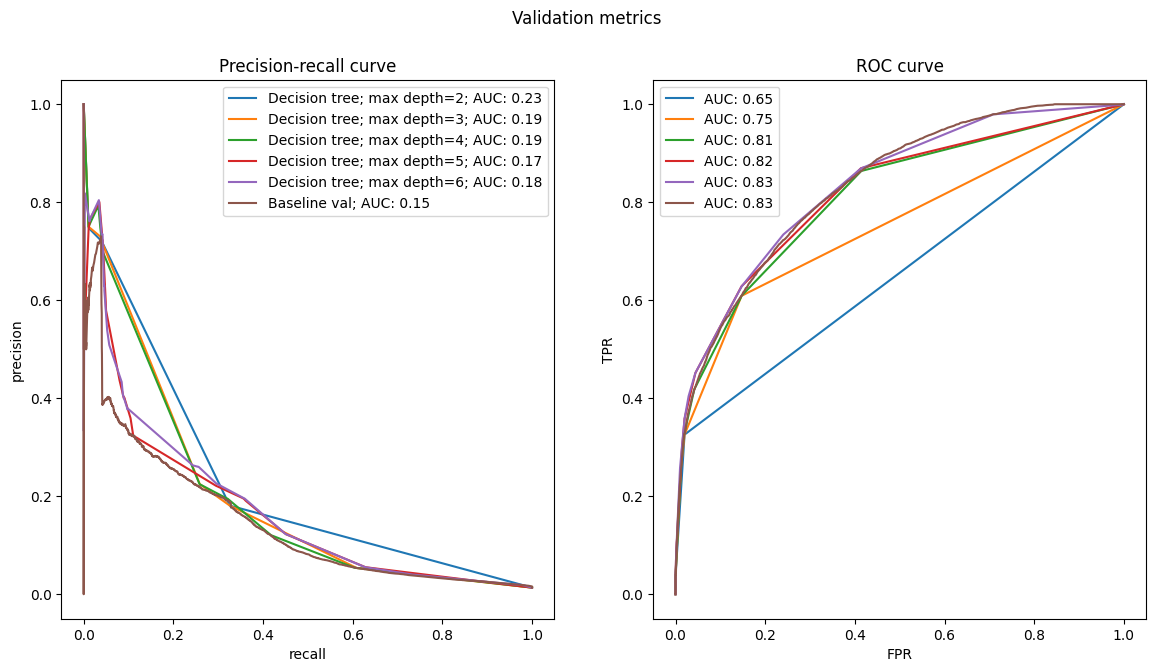

In [70]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


max_depth = [2, 3, 4, 5, 6]
for m_d in max_depth:
    dt = make_pipeline(
        DecisionTreeClassifier(max_depth=m_d)
    )
    dt.fit(X_train[train_cols], y_train)
    dt_train_proba = dt.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"Decision tree; max depth={m_d}", y_pred=dt_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
    )

    dt_val_proba = dt.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"Decision tree; max depth={m_d}", y_pred=dt_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
    )


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)



El arbol con mejor AUC en PR curve es con profundidad 3, no obstante hace algo de overfitting ya que pasa de 0.22 en train a 0.19 en validación. Además, en la curva ROC, el rendimiento es mucho mas bajo que el resto.

En este caso, el mejor modelo seria max_depth = 4, con AUC en PR de train de 0.21 y AUC  en PR de val de 0.19

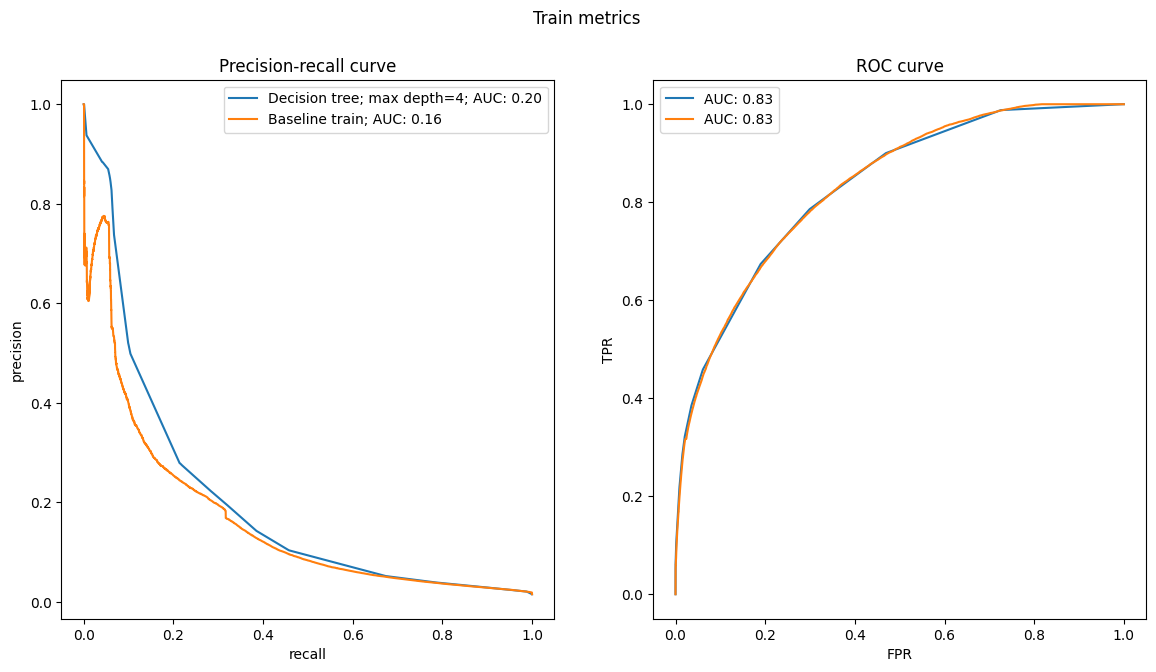

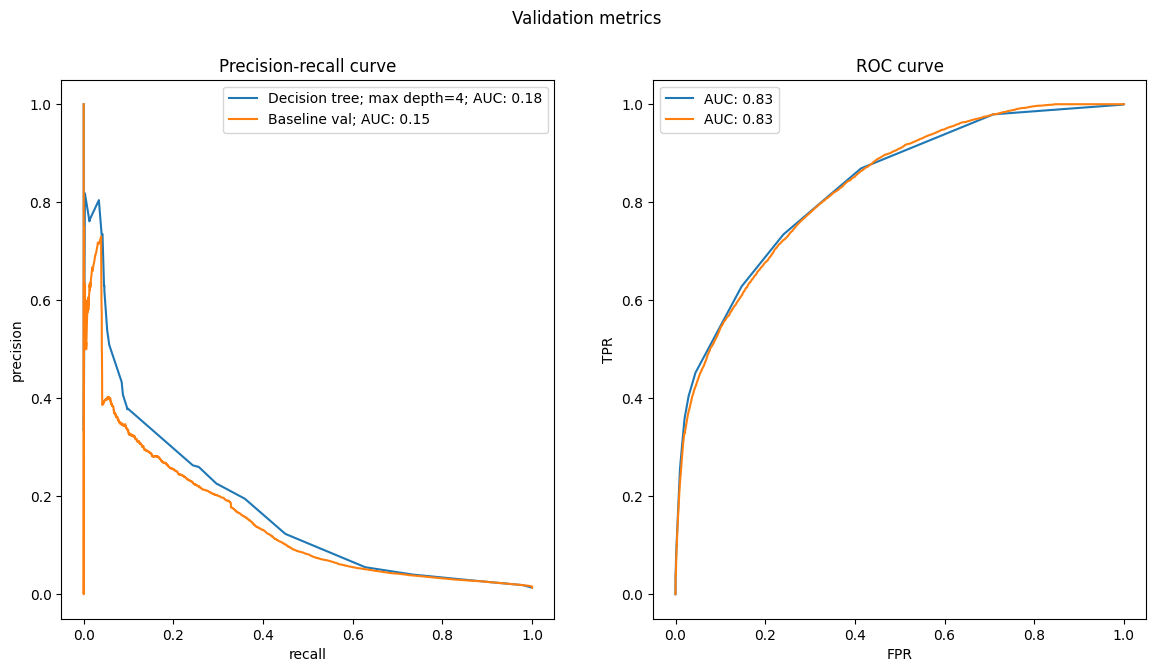

In [74]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

selected_max_depth = 4

selected_dt = make_pipeline(
    DecisionTreeClassifier(max_depth=selected_max_depth)
)
dt.fit(X_train[train_cols], y_train)
dt_train_proba = dt.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"Decision tree; max depth={selected_max_depth}", y_pred=dt_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

dt_val_proba = dt.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"Decision tree; max depth={selected_max_depth}", y_pred=dt_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)

plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)
plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

Vamos a incluir ahora las variables categoricas

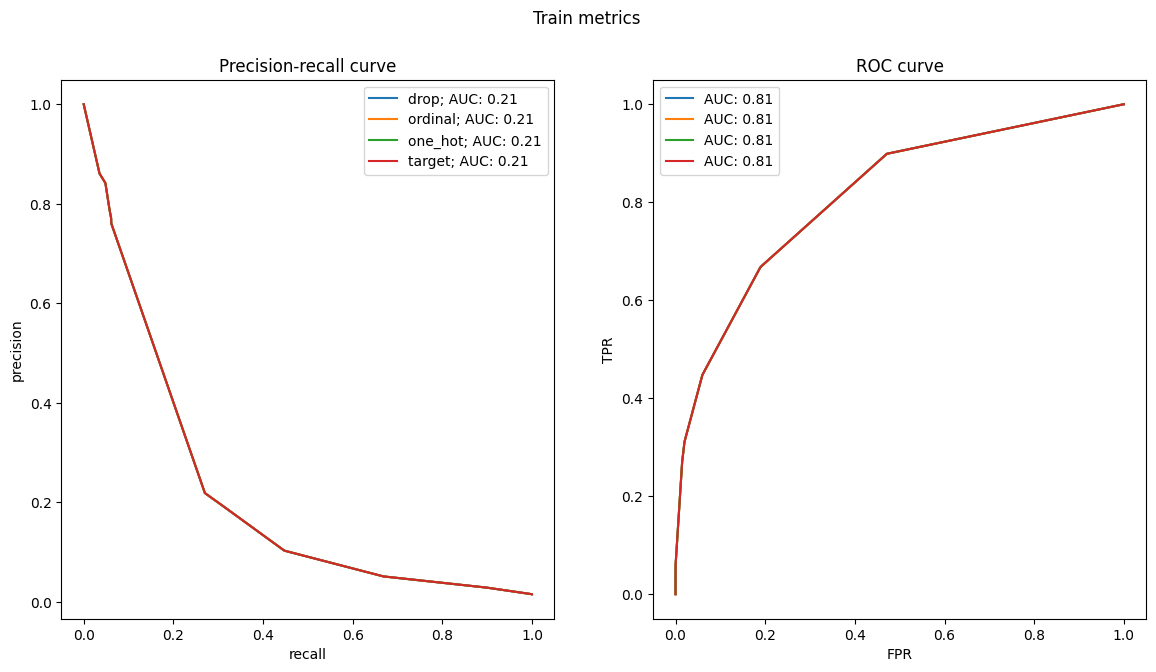

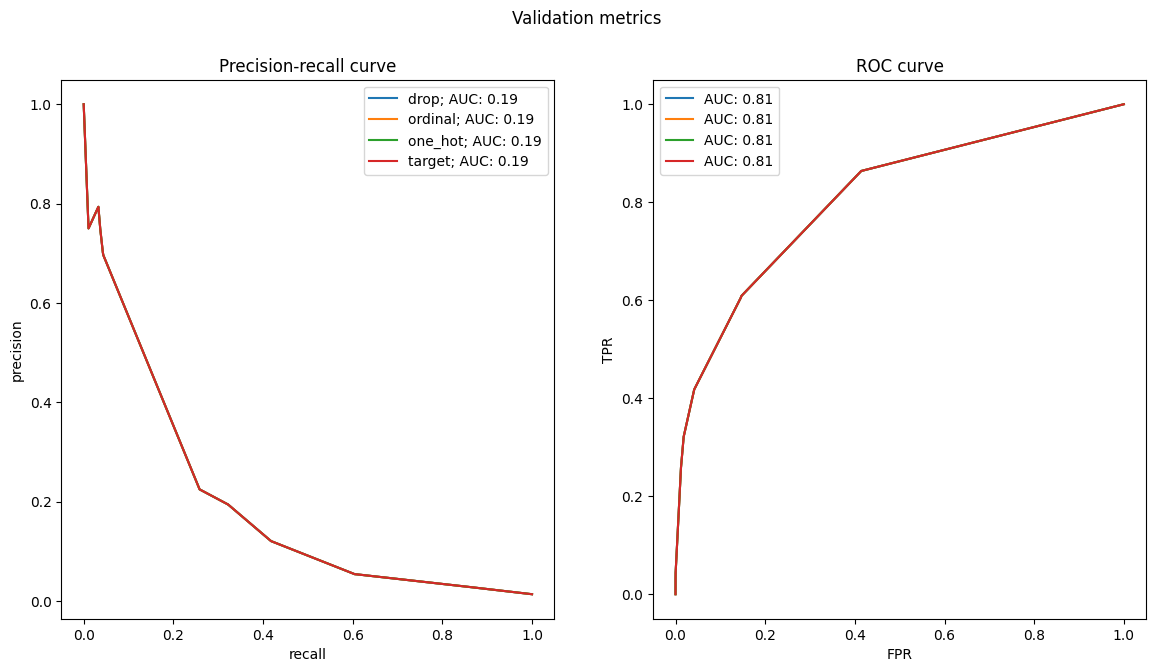

In [95]:
extended_cols = train_cols + categorical_cols

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("one_hot", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),),
    ("target", TargetEncoder(target_type="continuous"))
]

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", train_cols),
            ("categorical", categorical_preprocessor, categorical_cols)
        ]
    )
    extended_dt = make_pipeline(
        preprocessor, DecisionTreeClassifier(max_depth=selected_max_depth)
    )

    extended_dt.fit(X_train[extended_cols], y_train)
    extended_dt_train_proba = extended_dt.predict_proba(X_train[extended_cols])[:, 1]
    plot_metrics(
        name, y_pred=extended_dt_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    extended_dt_val_proba = extended_dt.predict_proba(X_val[extended_cols])[:, 1]
    plot_metrics(name, y_pred=extended_dt_val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

En este caso, incluir las variables categoricas si mejora el rendimiento un poco, todas ellas por igual, aunque la diferencia entre 0.21 y 0.19 es una señal de overfit.

# Random Forest

In [83]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [4, 7, None],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)

grid_search.fit(X_train[train_cols], train_df[label_col])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.5s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.4s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  15.6s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  16.1s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  16.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  47.3s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  48.3s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  50.0s
[CV] END max_depth=4, min_samples_leaf=2,

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 7, None], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [4, 8],
                         'n_estimators': [50, 100, 300]},
             scoring='roc_auc', verbose=2)

In [84]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación (AUC-ROC):", grid_search.best_score_)

Mejores hiperparámetros: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
Mejor puntuación (AUC-ROC): 0.8302371774059504


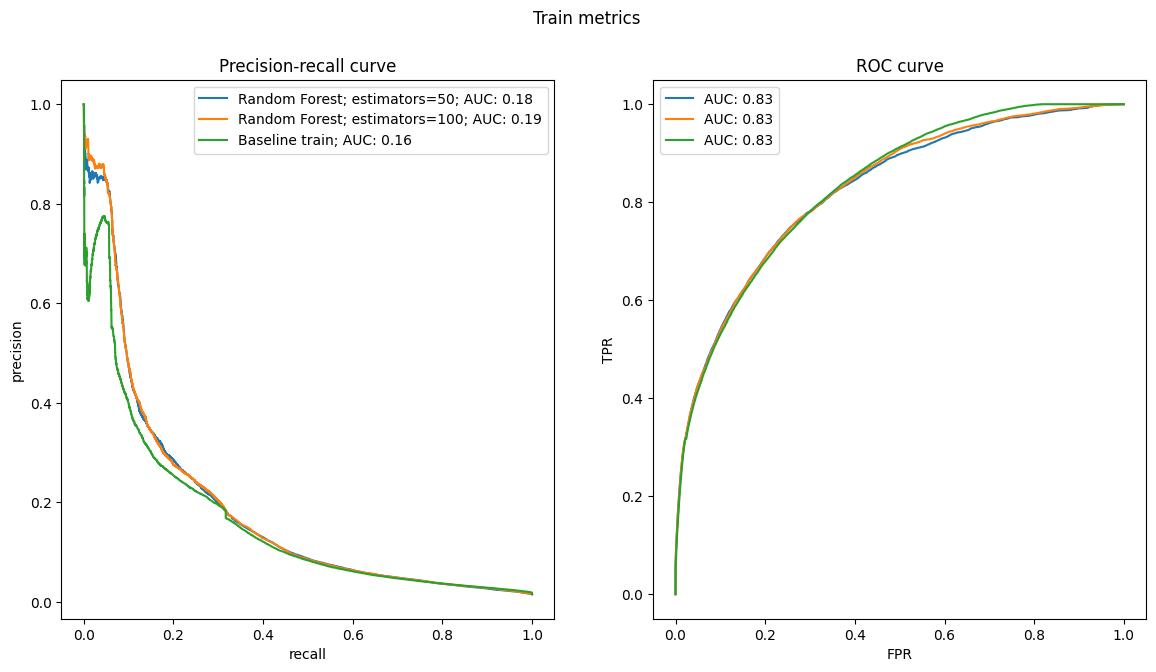

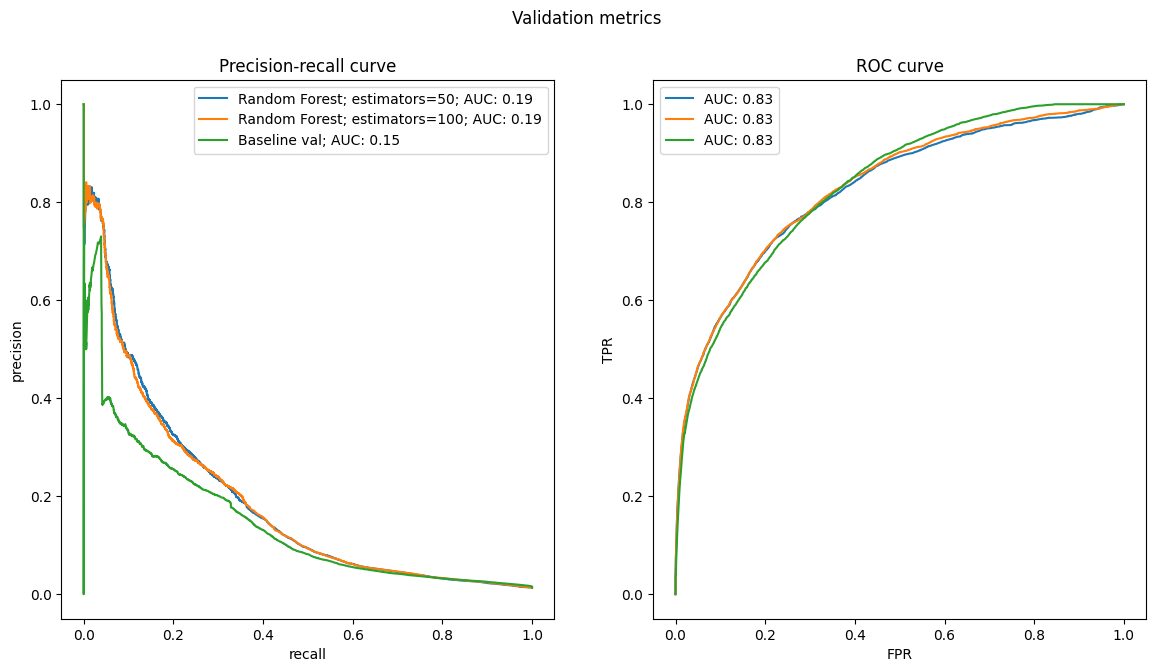

In [103]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


n_estimators = [50, 100]
max_depth_ = 4
min_samples_split_ = 4
min_samples_leaf_ = 4
for n_esti in n_estimators:
    rf = make_pipeline(
        RandomForestClassifier(n_estimators= n_esti, max_depth=max_depth_, min_samples_split=min_samples_split_, min_samples_leaf=min_samples_leaf_)
    )
    rf.fit(X_train[train_cols], y_train)
    rf_train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
    )

    rf_val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
    )


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

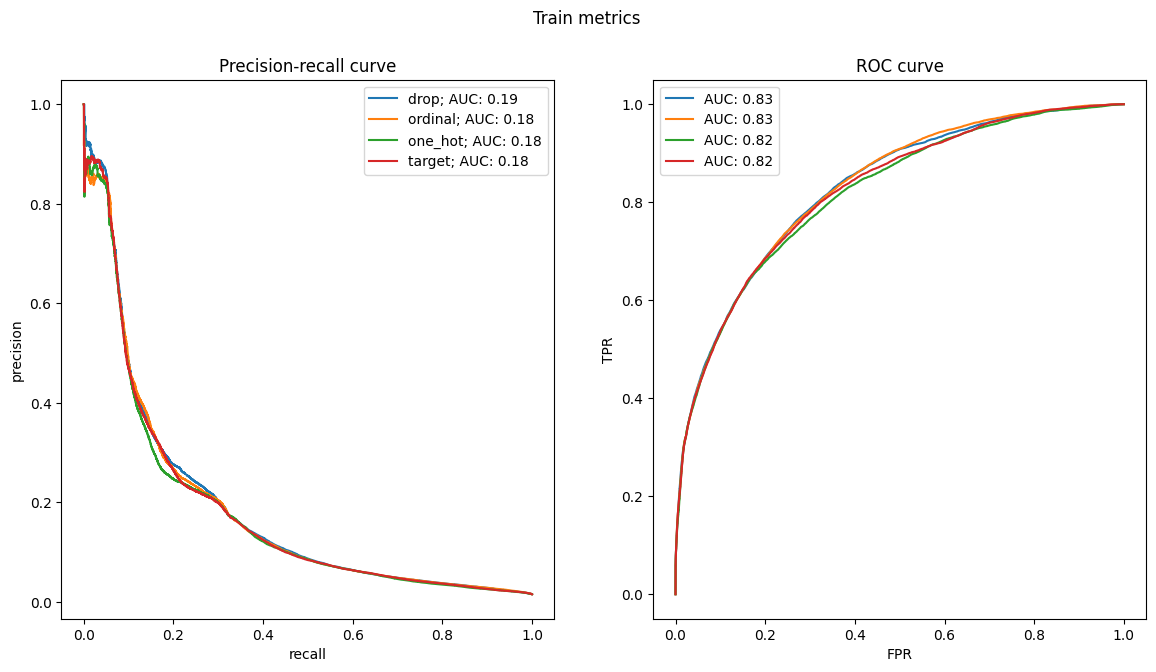

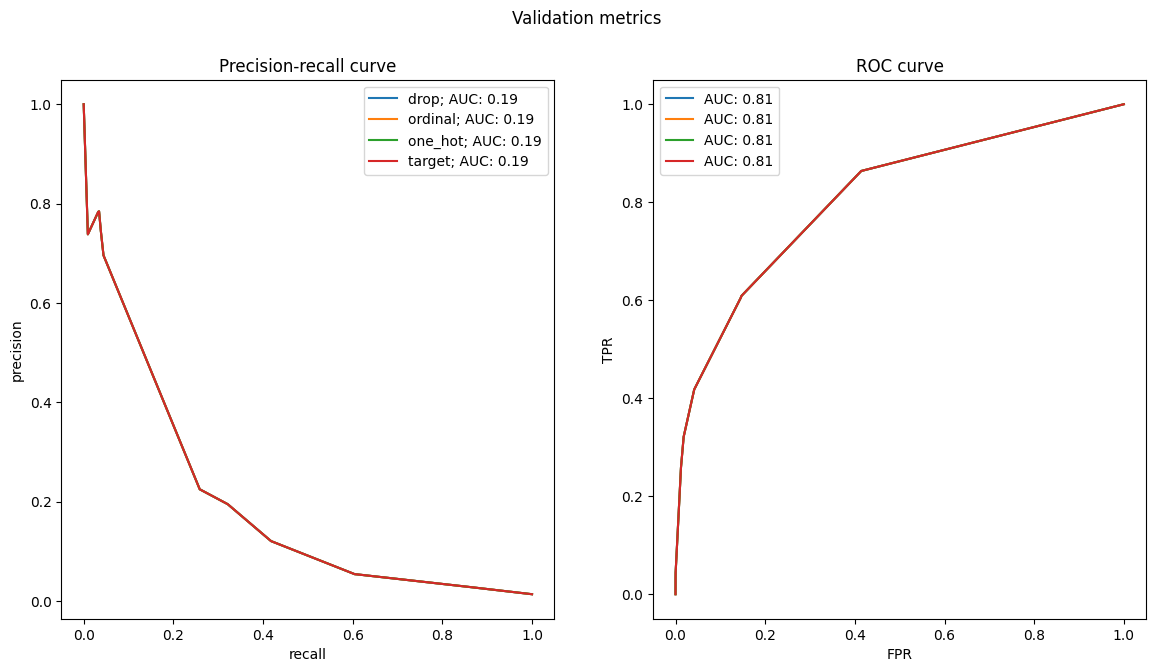

In [94]:

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("one_hot", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),),
    ("target", TargetEncoder(target_type="continuous"))
]

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", train_cols),
            ("categorical", categorical_preprocessor, categorical_cols)
        ]
    )
    extended_rf = make_pipeline(
        preprocessor, RandomForestClassifier(n_estimators= n_esti, max_depth=max_depth_, min_samples_split=min_samples_split_, min_samples_leaf=min_samples_leaf_)
    )

    extended_rf.fit(X_train[extended_cols], y_train)
    extended_rf_train_proba = extended_rf.predict_proba(X_train[extended_cols])[:, 1]
    plot_metrics(
        name, y_pred=extended_rf_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    extended_rf_val_proba = extended_dt.predict_proba(X_val[extended_cols])[:, 1]
    plot_metrics(name, y_pred=extended_rf_val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

Los resultados de Decision Tree y Random Forest son muy similares, no esta aportando mucho valor el añadir arboles (si que aporta valor en el sentido de que tenemos menos overfit, las AUC son similares en train y val). 

Duda: Error de train en Random Forest no nos importa, entonces en este modelo solo tenemos que preocuparnos por que aumente el AUC sobre validación ?

# Gradient Boosting trees

Los hiperparametros afectan mucho

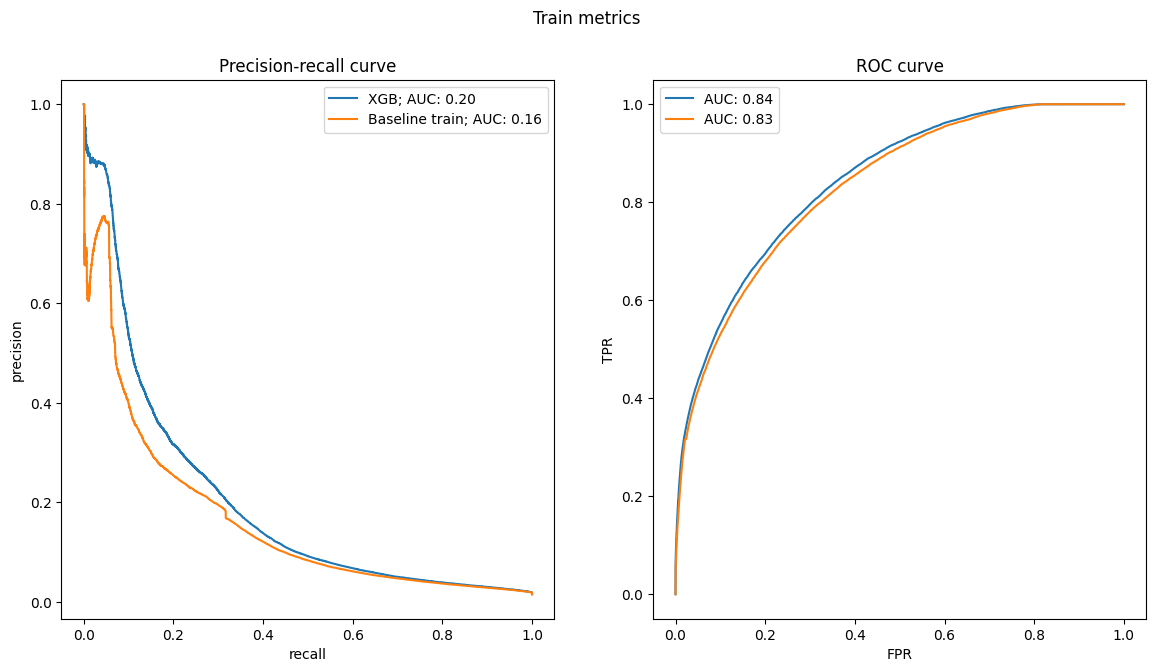

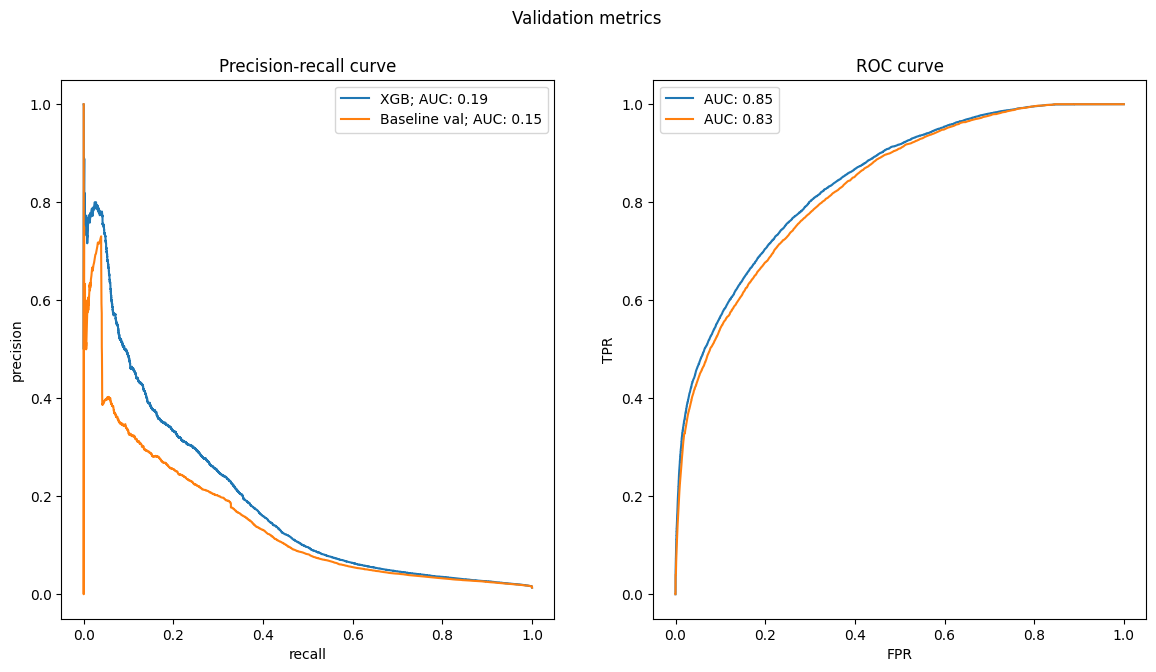

In [104]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")




xg = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,            
    max_depth=3,                 
    learning_rate=0.1,         
    subsample=0.8,            
    colsample_bytree=0.8         
)
)

xg.fit(X_train[train_cols], y_train)
xg_train_proba = xg.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

xg_val_proba = xg.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

In [106]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [3, 5, 7, 9],            # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],    # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],         #Submuestra de datos para cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0],  #Submuestra de características para cada árbol
    'reg_alpha': [0, 0.1, 1],             # Regularización L1 (alpha)
    'reg_lambda': [0, 0.1, 1],            # Regularización L2 (lambda)
    'gamma': [0, 0.1, 0.2],               # Reducción mínima de pérdida para dividir un nodo
}

In [109]:
# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Configurar Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    scoring='roc_auc',  # Métrica a optimizar (AUC-ROC)
    cv=3,               # Número de folds en la validación cruzada
    n_jobs=-1,          # Usar todos los núcleos del CPU
    verbose=2,          # Mostrar mensajes de progreso
    random_state=42      # Semilla para reproducibilidad
)

In [110]:
# Ejecutar Randomized Search
random_search.fit(X_train[train_cols], y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación (AUC-ROC):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s
[CV] END colsample_b

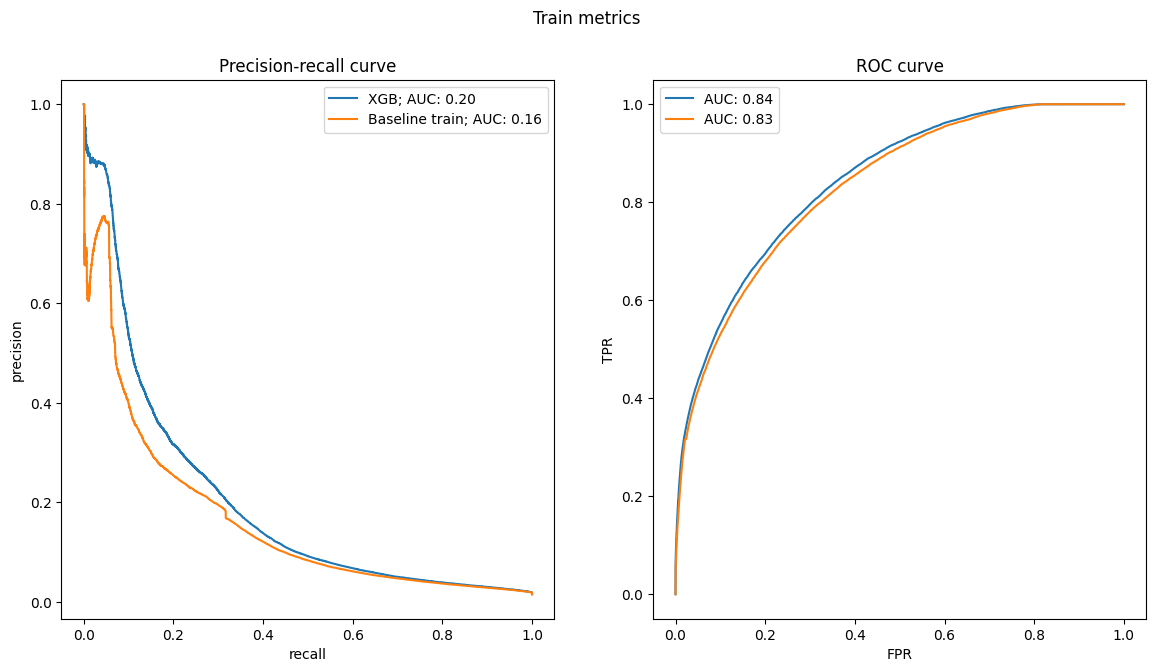

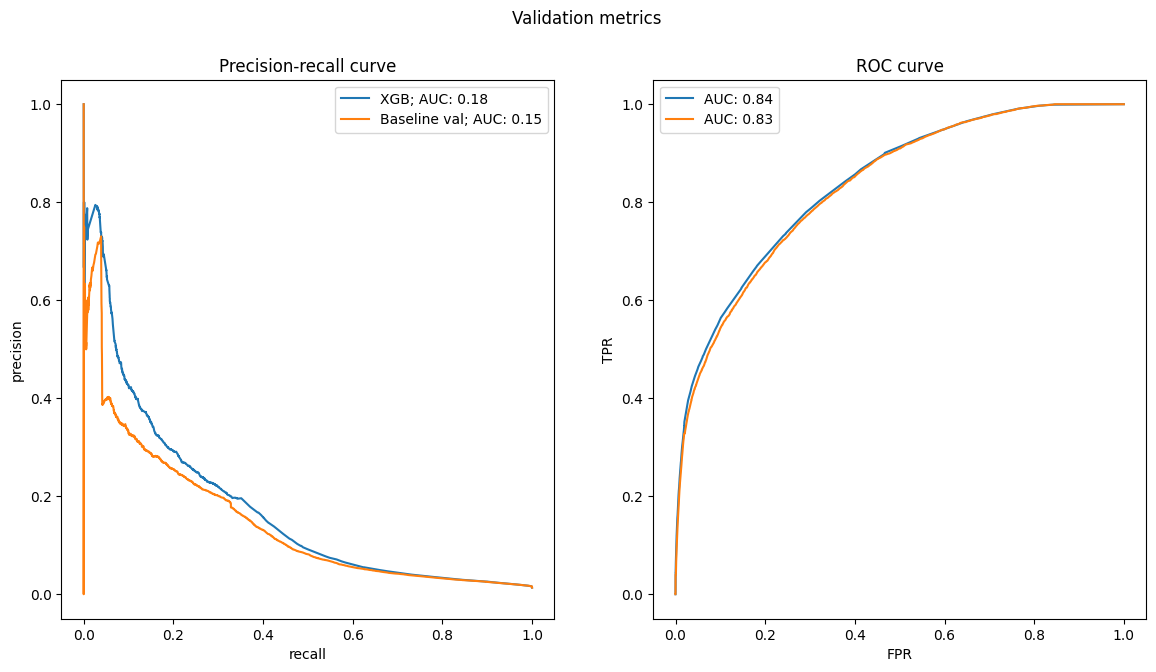

In [111]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


random_xg = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=300,            
    max_depth=3,                 
    learning_rate=0.01,         
    subsample=1.0,            
    colsample_bytree=1.0,
    reg_lambda= 0.1,
    reg_alpha=0.1,
    gamma= 0.1        
)
)

random_xg.fit(X_train[train_cols], y_train)
random_xg_train_proba = xg.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=random_xg_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

random_xg_val_proba = random_xg.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=random_xg_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)